In [41]:
from datetime import datetime, timedelta
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import random
import uuid

sns.set()
fake = Faker()

Criação dos colaboradores

In [42]:
qtd_of_workers = 40
worker_ids = [fake.name() for _ in range(qtd_of_workers)]
worker_last_releases = [datetime(2021, 10, 1, 00, 00) for _ in range(qtd_of_workers)]

Criação dos tipos de tarefas

In [43]:
qtd_of_task_types = 4
duration_hour = [4, 12, 36, 72]
task_types = [(i, duration_hour[i]) for i in range(qtd_of_task_types)]
task_type_ids = list(map(lambda x: x[0], task_types))

Criação de tarefas e distribuição em um período de 30 dias


Para simplificar, foi defido dois dias sequenciais aleatórios intercalados por cinco dias para representar os finais de semana

In [44]:
tasks = []
date_start = datetime(2021, 10, 1)

def gen_task(days_from_start):
    begin_hour = random.choice([8, 12, 16, 18])
    start = date_start + timedelta(days=days_from_start, hours=begin_hour)

    task_type = random.choices(task_types, [50, 30, 10, 10])[0]
    
    end = start + timedelta(hours=task_type[1])
    
    return (start, end, task_type[0])

for i in range(30):
    qtd = random.randint(2, 4) if i%7 in [5,6] else random.randint(6, 10)
    for _ in range(qtd):
        tasks.append(gen_task(i))

tasks.sort(key=lambda x: x[0])

Apresenta a distribuição de tarefas geradas para analise dos algorítimos

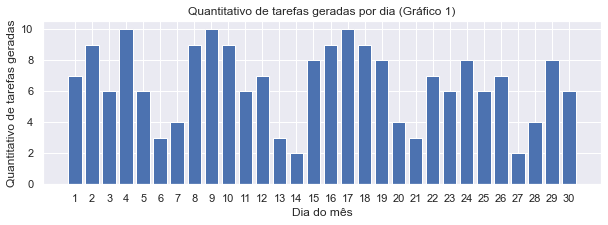

In [45]:
# Grafico 1
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

tasks_days = [math.trunc((task[0].timestamp() - date_start.timestamp()) / (24 * 60 * 60)) + 1 for task in tasks]
ax.bar(*np.unique(tasks_days, return_counts=True))
ax.set_xticks([i + 1 for i in range(30)])

plt.ylabel('Quantitativo de tarefas geradas')
plt.xlabel('Dia do mês')
plt.title('Quantitativo de tarefas geradas por dia (Gráfico 1)')

plt.show()

Define uma função para atribuição de uma tarefa a um colaborador de forma sequencial

In [46]:
def get_sequence_assign ():
    cache = 0
    workers_len = len(worker_ids)
    def sequence_assign():
        nonlocal cache
        worker = worker_ids[cache%workers_len]
        cache = cache + 1
        return worker 
    
    return sequence_assign

Define uma função para atribuição de uma tarefa a um colaborador dada a função de reconpença *R*:

$ R (s, a, s') = intervalo $

Nesta função, R representa a recompensa que o agente recebe durante a transição do status s para s’ ao escolher a ação a e intervalo representa o tamanho do intervalo de tempo de repouso do colaborador (última liberação até início da corrente atribuição)

In [47]:
def get_reward_function_assign ():
    lr_cache = worker_last_releases.copy()
    def reward_function_assign(task):
        nonlocal lr_cache
        start, end, _ = task
        time_resting = [(start.timestamp() - last_release.timestamp()) /  (24 * 60 * 60) for last_release in lr_cache]
        worker_idx = np.argmax(time_resting)
        lr_cache[worker_idx] = end
        return worker_ids[worker_idx]

    return reward_function_assign

Realiza a distribuição das tarefas geradas para os colaboradores criados

In [48]:
sequence_assign = get_sequence_assign()
sequence_assignment = [sequence_assign() for _ in tasks]

reward_function_assign = get_reward_function_assign()
reward_function_assignment = [reward_function_assign(task) for task in tasks]

Os encargos móveis são atividades não compreendidas nos deveres diários do serviço administrativo de um setor, dessa forma busca-se equilibrar o quantitativo de tempo de disponibilidade dos colaboradores em seus setores. Podemos quantificar e verificar a distribuição do tempo de disponibilidade de um colaborador pelo somatório dos intervalos de tempo entre a data da cada disponibilização para o serviço no setor até o início do próximo encargo.  

In [49]:
def get_availability_interval (assignment):
    availability_interval_sum = [] # total de tempo disponível
    for idx, worker_id in enumerate(worker_ids): # for each worker
        last_release = worker_last_releases[idx] # start fist availability
        assignments = [idx for idx in range(len(tasks)) if worker_id == assignment[idx]] # get indexes of tasks assigned
        availability_interval = []
        for idx in assignments:
            task_start, task_end, _ = tasks[idx]
            availability_interval.append((task_start - last_release).total_seconds() /  (24 * 60 * 60))
            last_release = task_end
        availability_interval_sum.append(sum(availability_interval))
        
    return availability_interval_sum

Quantifica a quantidade total de tempo de disponibilidade do colaborador para o setor após cada atribuição

In [50]:
# total de tempo disponível
seq_availability_interval_sum = get_availability_interval(sequence_assignment)
r_availability_interval_sum = get_availability_interval(reward_function_assignment)

Apresenta a distribuição do somatório de disponibilidade em horas para cada usuário

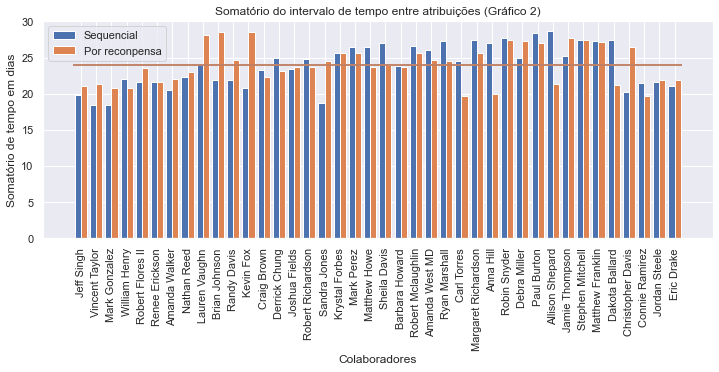

In [51]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

X_len = np.arange(len(seq_availability_interval_sum))

ax.bar(X_len - .2, seq_availability_interval_sum, .4, label='Sequencial')
ax.bar(X_len + .2, r_availability_interval_sum, .4, label='Por reconpensa')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.hlines(y=np.mean(seq_availability_interval_sum), xmin=-.5, xmax=len(worker_ids) - .5, color=colors[0])
ax.hlines(y=np.mean(r_availability_interval_sum), xmin=-.5, xmax=len(worker_ids) - .5,  color=colors[1])

plt.xticks(X_len, worker_ids, rotation='vertical')
plt.title('Somatório do intervalo de tempo entre atribuições (Gráfico 2)')
plt.xlabel('Colaboradores')
plt.ylabel('Somatório de tempo em dias')
plt.legend()
plt.show()

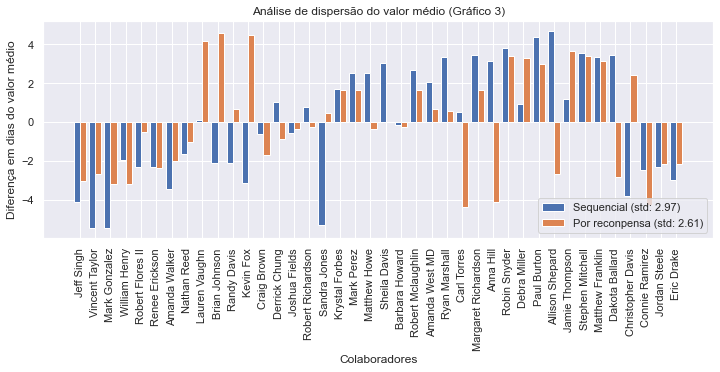

In [52]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

X_len = np.arange(len(r_availability_interval_sum))

np_seq_availability_interval_sum = np.array(seq_availability_interval_sum)
X1 = np_seq_availability_interval_sum - np_seq_availability_interval_sum.mean()

np_r_availability_interval_sum = np.array(r_availability_interval_sum)
X2 = np_r_availability_interval_sum - np_r_availability_interval_sum.mean()


ax.bar(X_len - .2, X1, .4, label='Sequencial (std: {})'.format(np.round(np_seq_availability_interval_sum.std(), 2)))
ax.bar(X_len + .2, X2, .4, label='Por reconpensa (std: {})'.format(np.round(np_r_availability_interval_sum.std(), 2)))

plt.xticks(X_len, worker_ids, rotation='vertical')
plt.title('Análise de dispersão do valor médio (Gráfico 3)')
plt.xlabel('Colaboradores')
plt.ylabel('Diferença em dias do valor médio')
plt.legend()
plt.show()

$$ \forall c \in colaboradores$$

$$ \forall i \in tipotarefas$$

$$ R (s, a_{ci}, s') = intervalo * (freqinvnorm_{ci} + 1) $$



$$ freqinvnorm_i = \frac{freqinv_i - \min{(freqinv)}}{\max{(freqinv)} - \min{(freqinv)}} $$

$$ freq inv_i = \frac{disponibilidade}{tarefa_i} $$

In [53]:
def cost_func (start, last_release, inverse_frequency):
    days_from_last_availability = (start.timestamp() - last_release.timestamp()) /  (24 * 60 * 60)
    if (days_from_last_availability < 0):
        return -1000
    days_from_last_availability *= (inverse_frequency + 1)
    return days_from_last_availability

def get_reward_function_assign_v2 ():
    lr_cache = worker_last_releases.copy()
    av_cache = np.zeros(len(worker_ids)) # availability
    tc_cache = np.ones((len(worker_ids), len(task_type_ids))) # qtd of each task assigned for each worker

    last_task_end = lr_cache[0]
    
    def reward_function_v2_assign(task):
        nonlocal lr_cache, av_cache, last_task_end
        start, end, type_id = task
        av_cache += (end.timestamp() - last_task_end.timestamp()) /  (24 * 60 * 60)
        
        inverse_task_frequencies = av_cache.reshape((len(worker_ids), 1)) / tc_cache
        ranges = (inverse_task_frequencies.max(axis=0) - inverse_task_frequencies.min(axis=0))
        ranges[ranges == 0] = 1
        inverse_task_frequencies_normed = (inverse_task_frequencies - inverse_task_frequencies.min(axis=0)) / ranges
        cost = [cost_func(start, lr_cache[idx], inverse_task_frequencies_normed[idx, type_id]) for idx in range(len(lr_cache))]
        worker_idx = np.argmax(cost)
        
        lr_cache[worker_idx] = end
        av_cache[worker_idx] -= (end.timestamp() - start.timestamp()) /  (24 * 60 * 60)
        tc_cache[worker_idx, type_id] += 1
        last_task_end = end
        return worker_ids[worker_idx]

    return reward_function_v2_assign

In [54]:
reward_function_v2_assign = get_reward_function_assign_v2()
reward_function_v2_assignment = [reward_function_v2_assign(task) for task in tasks]

In [55]:
# total de tempo disponível
r2_availability_interval_sum = get_availability_interval(reward_function_v2_assignment)

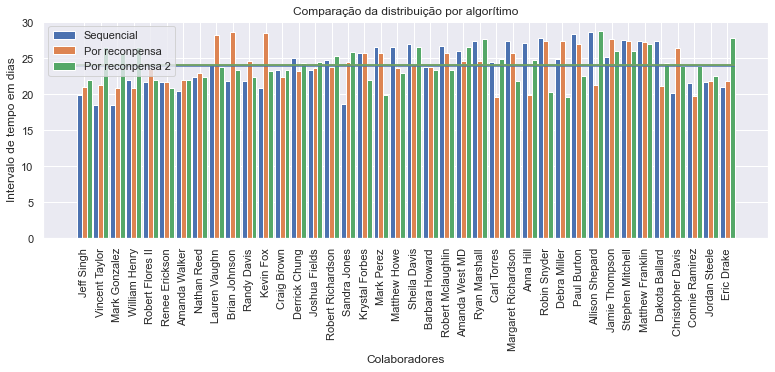

In [56]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 4))

X_len = np.arange(len(seq_availability_interval_sum))

ax.bar(X_len - .3, seq_availability_interval_sum, .3, label='Sequencial')
ax.bar(X_len, r_availability_interval_sum, .3, label='Por reconpensa')
ax.bar(X_len + .3, r2_availability_interval_sum, .3, label='Por reconpensa 2')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.hlines(y=np.mean(seq_availability_interval_sum), xmin=-.5, xmax=len(worker_ids) - .5, color=colors[0])
ax.hlines(y=np.mean(r_availability_interval_sum), xmin=-.5, xmax=len(worker_ids) - .5,  color=colors[1])
ax.hlines(y=np.mean(r2_availability_interval_sum), xmin=-.5, xmax=len(worker_ids) - .5,  color=colors[2])

plt.xticks(X_len, worker_ids, rotation='vertical')
plt.title('Comparação da distribuição por algorítimo')
plt.xlabel('Colaboradores')
plt.ylabel('Intervalo de tempo em dias')
plt.legend()
plt.show()

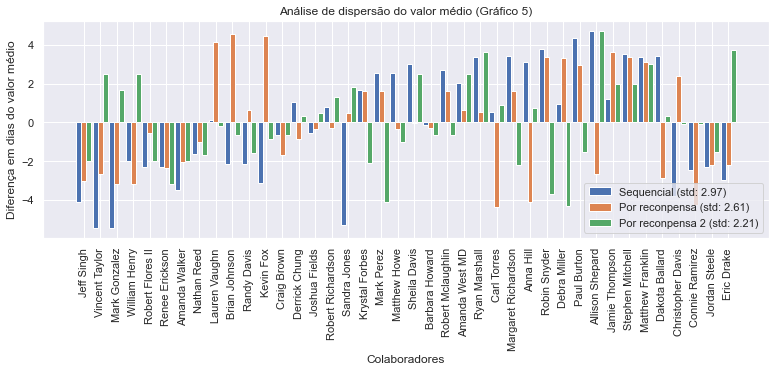

In [57]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 4))

X_len = np.arange(len(r_availability_interval_sum))

np_seq_availability_interval_sum = np.array(seq_availability_interval_sum)
X1 = np_seq_availability_interval_sum - np_seq_availability_interval_sum.mean()

np_r_availability_interval_sum = np.array(r_availability_interval_sum)
X2 = np_r_availability_interval_sum - np_r_availability_interval_sum.mean()

np_r2_availability_interval_sum = np.array(r2_availability_interval_sum)
X3 = np_r2_availability_interval_sum - np_r2_availability_interval_sum.mean()

ax.bar(X_len - .3, X1, .3, label='Sequencial (std: {})'.format(np.round(np_seq_availability_interval_sum.std(), 2)))
ax.bar(X_len, X2, .3, label='Por reconpensa (std: {})'.format(np.round(np_r_availability_interval_sum.std(), 2)))
ax.bar(X_len + .3, X3, .3, label='Por reconpensa 2 (std: {})'.format(np.round(np_r2_availability_interval_sum.std(), 2)))

plt.xticks(X_len, worker_ids, rotation='vertical')
plt.title('Análise de dispersão do valor médio (Gráfico 5)')
plt.xlabel('Colaboradores')
plt.ylabel('Diferença em dias do valor médio')
plt.legend()
plt.show()

In [58]:
seq_task_type_count = np.zeros((len(worker_ids), len(task_type_ids)))
for idx, worker_id in enumerate(sequence_assignment):
    worker_idx = worker_ids.index(worker_id)
    seq_task_type_count[worker_idx, tasks[idx][2]] += 1

r_task_type_count = np.zeros((len(worker_ids), len(task_type_ids)))
for idx, worker_id in enumerate(reward_function_assignment):
    worker_idx = worker_ids.index(worker_id)
    r_task_type_count[worker_idx, tasks[idx][2]] += 1
    
r2_task_type_count = np.zeros((len(worker_ids), len(task_type_ids)))
for idx, worker_id in enumerate(reward_function_v2_assignment):
    worker_idx = worker_ids.index(worker_id)
    r2_task_type_count[worker_idx, tasks[idx][2]] += 1

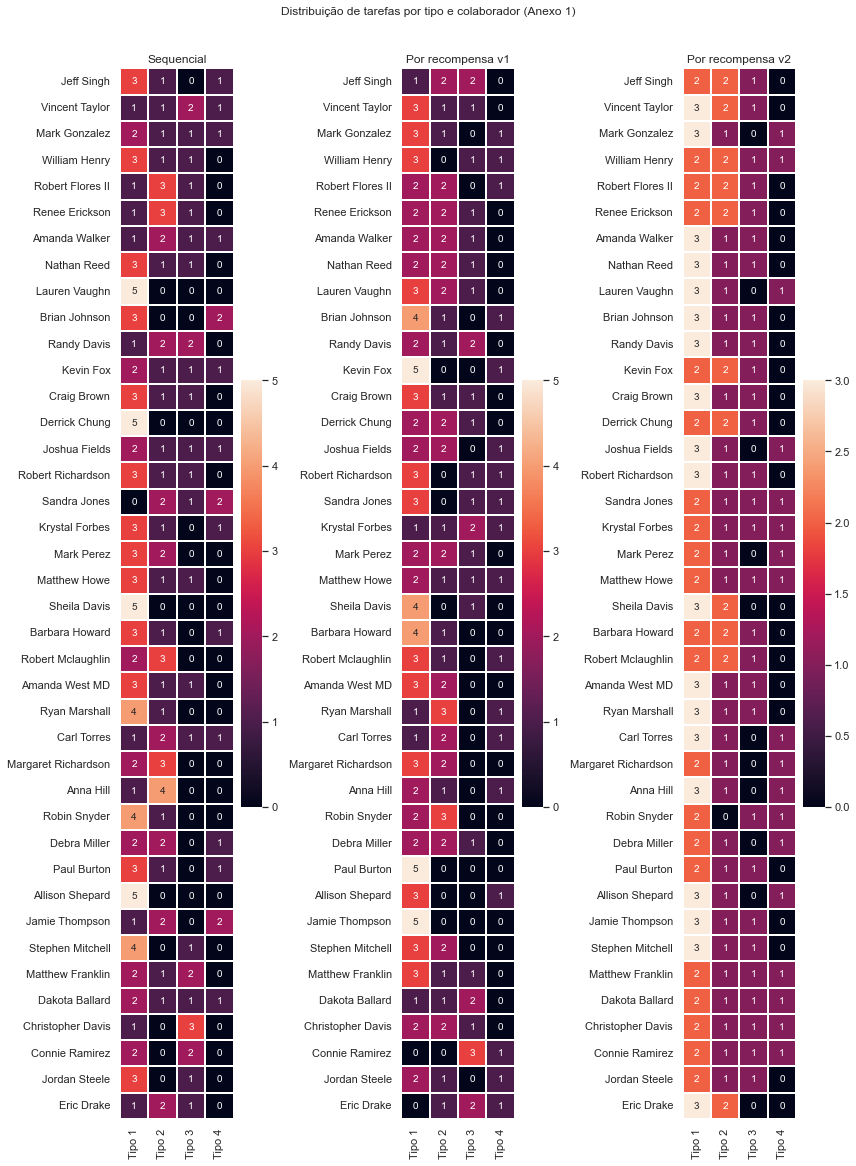

In [59]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12, 17))

tasks_types_labels = list(map(lambda x: "Tipo {}".format(x + 1),task_type_ids))

sns.heatmap(seq_task_type_count, linewidth=0.3, annot=True, ax=ax1)
ax1.set_xticklabels(tasks_types_labels, rotation='vertical')
ax1.set_yticklabels(worker_ids, rotation='horizontal')
ax1.set_title("Sequencial")

sns.heatmap(r_task_type_count, linewidth=0.3, annot=True, ax=ax2)
ax2.set_xticklabels(tasks_types_labels, rotation='vertical')
ax2.set_yticklabels(worker_ids, rotation='horizontal')
ax2.set_title("Por recompensa v1")

sns.heatmap(r2_task_type_count, linewidth=0.3, annot=True, ax=ax3)
ax3.set_xticklabels(tasks_types_labels, rotation='vertical')
ax3.set_yticklabels(worker_ids, rotation='horizontal')
ax3.set_title("Por recompensa v2")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Distribuição de tarefas por tipo e colaborador (Anexo 1)")
plt.show()

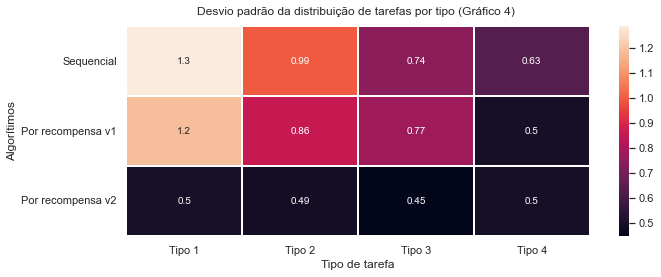

In [60]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

data=[
    seq_task_type_count.std(axis=0),
    r_task_type_count.std(axis=0),
    r2_task_type_count.std(axis=0),
]

tasks_types_labels = list(map(lambda x: "Tipo {}".format(x + 1),task_type_ids))
rowLables = ["Sequencial", "Por recompensa v1", "Por recompensa v2"]

sns.heatmap(data, linewidth=0.3, annot=True, ax=ax1)
ax1.set_xticklabels(tasks_types_labels)
ax1.set_yticklabels(rowLables, rotation='horizontal')
ax1.set_xlabel("Tipo de tarefa")
ax1.set_ylabel("Algorítimos")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Desvio padrão da distribuição de tarefas por tipo (Gráfico 4)")
plt.show()